In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    primeira = 1
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        print(f"Tempo: {t}")
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        if isinstance(t, float):
             rho_vector[0][int(round(t,0))+r] = pt[0][0]
             rho_vector[1][int(round(t,0))+r] = pt[0][1]
             rho_vector[2][int(round(t,0))+r] = pt[1][0]
             rho_vector[3][int(round(t,0))+r] = pt[1][1]
             r += 1
        else:
            rho_vector[0][t] = pt[0][0]
            rho_vector[1][t] = pt[0][1]
            rho_vector[2][t] = pt[1][0]
            rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        # if 1/2*(1+rt[2][0]) > 0.9995:
        #     distance_vector.pop()
        #     fx_vector.pop()
        #     fy_vector.pop()
        #     fz_vector.pop()
        #     fid_vector.pop()
        #     fid_autores.pop()
        #     resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        #     u[0] = resultado_algoritmo_genetico[0]
        #     u[1] = resultado_algoritmo_genetico[1]
        #     u[2] = resultado_algoritmo_genetico[2]
        while 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
            print(f"Processo de infactibilidade")
            print(f"Porta: {fid_autores[-1]}")
            print(f"Estados: {fid_vector[-1]}")
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            aas[-1] = ((u[0],u[1],u[2]))
        
        if t <= 70:
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
        elif t > 70:
            h = 0.001
            if primeira:
                while D > 5*10**(-3):
                    resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
                    u[0] = resultado_algoritmo_genetico[0]
                    u[1] = resultado_algoritmo_genetico[1]
                    u[2] = resultado_algoritmo_genetico[2]
                    a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
                    rt = np.dot(Uto, r0)
                    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
                    fid_v = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
                    fid_a = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
                    distancia = np.linalg.norm(Uto-Uf)**2
                    if 1/2*(1+rt[2][0]) > 1 or fid_a > 1 or fid_v > 1:
                        print(f"Repetindo, houve infactibilidade.")
                    else:
                        fid_vector[-1] = fid_v
                        fid_autores[-1] = fid_a
                        aaas = ((u[0],u[1],u[2]))
                        D = distancia
                        Ut = Uto
                        t += 1
                t = 71
                t += 1
                primeira = 0
            else:
                print(f"Alcançou-se um valor desejável")
                resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
                u[0] = resultado_algoritmo_genetico[0]
                u[1] = resultado_algoritmo_genetico[1]
                u[2] = resultado_algoritmo_genetico[2]
                t += 1
        Ut = Uto

    print(f"O rho gerado foi: {pt}") 
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Tempo: 0
Tempo: 1
Tempo: 2
Tempo: 3
Tempo: 4
Tempo: 5
Tempo: 6
Tempo: 7
Tempo: 8
Tempo: 9
Tempo: 10
Tempo: 11
Tempo: 12
Tempo: 13
Tempo: 14
Tempo: 15
Tempo: 16
Tempo: 17
Tempo: 18
Tempo: 19
Tempo: 20
Tempo: 21
Tempo: 22
Tempo: 23
Tempo: 24
Tempo: 25
Tempo: 26
Tempo: 27
Tempo: 28
Tempo: 29
Tempo: 30
Tempo: 31
Tempo: 32
Tempo: 33
Processo de infactibilidade
Porta: 1.0002205800966577
Estados: (0.9988000494674524+0.00010171826320149721j)
Tempo: 34
Tempo: 35
Tempo: 36
Processo de infactibilidade
Porta: 1.0031738091840066
Estados: (1.0003385658886104+5.3014471426562797e-05j)
Tempo: 37
Processo de infactibilidade
Porta: 1.004892710839138
Estados: (1.0011938479427727+3.8496352941684544e-05j)
Tempo: 38
Tempo: 39
Tempo: 40
Tempo: 41
Tempo: 42
Tempo: 43
Tempo: 44
Tempo: 45
Processo de infactibilidade
Porta: 1.011559756706766
Estados: (1.0045549701547403+9.00384797146592e-07j)
Processo de infactibilidade
Porta: 1.0119310778683024
Estados: (1.004711427496536-2.8637679348

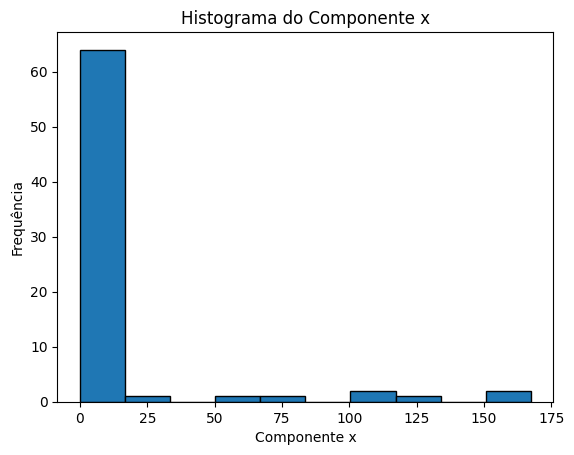

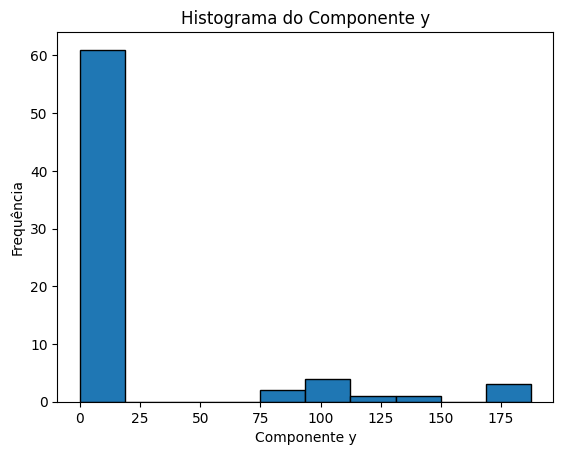

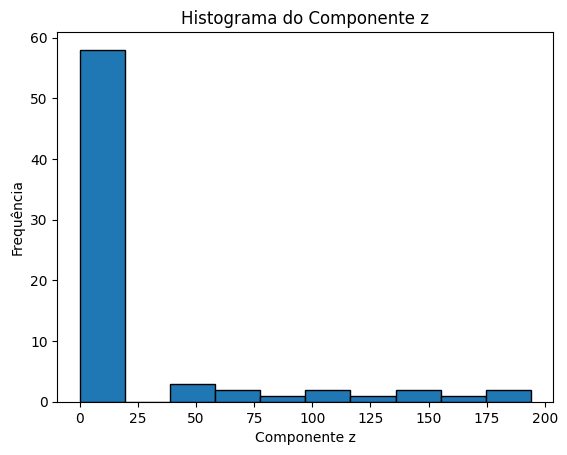

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9972434168162837
Estados: (0.999854487982851-6.901788883065419e-06j)
Distância: 0.0023231246382026814
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[np.clongdouble('0.5002049224555920248-7.12144218946039298e-08j'),
 np.clongdouble('0.4129245851618107201+0.00013130205605705161j'),
 np.clongdouble('0.4128282861379042323+5.5431428083837216924e-05j'),
 np.clongdouble('0.41297492154217804234+1.744208101723372687e-05j'),
 np.clongdouble('0.41578363464690931944-0.00011136728373618739181j'),
 np.clongdouble('0.43070153855210752548-2.7530527089306586708e-05j'),
 np.clongdouble('0.43079410952358384264+4.3748969523371778684e-05j'),
 np.clongdouble('0.4305962342068274259-8.8017045746188339866e-05j'),
 np.clongdouble('0.43072443979706438274+4.601095890338885189e-05j'),
 np.clongdouble('0.6249469885014927983-8.767776548120470718e-05j'),
 np.clongdouble('0.62564784365210426116-8.502285346454320854e-06j'),
 np.clongdouble('0.62536423845153310574-0.00017656122881520463646j'),
 np.clongdouble('0.6128652450623399117-0.00029104988377892789053j'),
 np.clongdouble('0.6813573682685444314-2.6598065050907975376e-05j'),
 np.clongdouble('0.67540288646073382

In [23]:
fid_autores

[np.float64(0.3333249317344352),
 np.float64(0.3383827145230391),
 np.float64(0.338350202123674),
 np.float64(0.3383443277668568),
 np.float64(0.32991847837671767),
 np.float64(0.3006102330294921),
 np.float64(0.2716565697020818),
 np.float64(0.2550115808082562),
 np.float64(0.25725740493047317),
 np.float64(0.31491601745879866),
 np.float64(0.31518646949796514),
 np.float64(0.3156300080381076),
 np.float64(0.32097158050951896),
 np.float64(0.36283456507495254),
 np.float64(0.36493148545176207),
 np.float64(0.3886172826941148),
 np.float64(0.4588852902569),
 np.float64(0.5023827036165992),
 np.float64(0.5320555606120667),
 np.float64(0.547825469416824),
 np.float64(0.558812172592541),
 np.float64(0.5610955516152557),
 np.float64(0.5623780718758248),
 np.float64(0.5826826165856049),
 np.float64(0.5843080494294267),
 np.float64(0.8018202016222548),
 np.float64(0.8026302666897404),
 np.float64(0.80428815114568),
 np.float64(0.8049049611270731),
 np.float64(0.8049055272744362),
 np.float64

In [24]:
rho_vector

array([[0.5       +0.j        , 0.41285439+0.j        ,
        0.41282816+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49999479-0.00045293j, 0.49998799+0.000322j  ,
        0.49997759+0.00047037j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49999479+0.00045293j, 0.49998799-0.000322j  ,
        0.49997759-0.00047037j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.5       +0.j        , 0.58714561+0.j        ,
        0.58717184+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[np.float64(7.9998991807048485),
 np.float64(8.060592574265497),
 np.float64(8.06020240531839),
 np.float64(8.060131914612345),
 np.float64(7.957111525927652),
 np.float64(7.5449868868095376),
 np.float64(6.973098920322884),
 np.float64(6.298482051542822),
 np.float64(5.627371669671785),
 np.float64(4.328396402157459),
 np.float64(4.324440837659812),
 np.float64(4.3180845756880215),
 np.float64(4.245398313791672),
 np.float64(3.7536604286233084),
 np.float64(3.7318838778133325),
 np.float64(3.4976772202721973),
 np.float64(2.9058196869626736),
 np.float64(2.589035928651054),
 np.float64(2.3888746258885325),
 np.float64(2.2871269756609234),
 np.float64(2.218270500519264),
 np.float64(2.203860857254628),
 np.float64(2.1957358134225524),
 np.float64(2.087134275597975),
 np.float64(2.0771937882045957),
 np.float64(0.9296422144167099),
 np.float64(0.9257376975103363),
 np.float64(0.9178971074593727),
 np.float64(0.9149178288245781),
 np.float64(0.9148020315012265),
 np.float64(0.91240684261

In [26]:
fx_vector

[np.float64(0.0),
 np.float64(1.193929567359442),
 np.float64(-36.940970237106576),
 np.float64(0.44004918249586655),
 -400,
 -400,
 np.float64(0.006018504733829057),
 np.float64(0.003611019029359075),
 np.float64(0.002206592266102757),
 -400,
 np.float64(-1.2038065197743464),
 np.float64(0.0010743970421918222),
 np.float64(0.0011079448135230844),
 np.float64(-135.65172990575888),
 np.float64(0.0008477500001633331),
 np.float64(0.0006035038871244153),
 np.float64(9.217075600823253e-05),
 np.float64(-88.34773235863094),
 np.float64(-8.009944969684737e-05),
 np.float64(-9.16020438850906e-05),
 np.float64(-0.025512021453165064),
 np.float64(-0.00015285987017831505),
 np.float64(-0.00015716231647361915),
 np.float64(-0.00014403891250734354),
 np.float64(-2.8114112933707585),
 np.float64(-274.83959526813305),
 np.float64(-1.4889610726485853),
 np.float64(-0.0007246285851825613),
 np.float64(-0.0007243614769429691),
 np.float64(-0.038447007052657786),
 np.float64(-0.9310635896315214),
 np.fl

In [27]:
fy_vector

[np.float64(0.0),
 np.float64(0.03698381422214801),
 np.float64(0.061994626180322254),
 np.float64(0.0619647826609637),
 np.float64(0.045509337145738606),
 np.float64(0.023527581176327146),
 np.float64(0.02514334942853296),
 np.float64(0.07415734937838259),
 np.float64(0.8619185778681382),
 np.float64(-0.009874513559034704),
 np.float64(-0.009951237899197258),
 np.float64(-0.009725711338754552),
 np.float64(70.59117718213415),
 np.float64(-0.022643694374653935),
 np.float64(22.586973231891207),
 np.float64(-0.006984028457607341),
 np.float64(-0.00023329212241627925),
 np.float64(0.00019375398742259005),
 np.float64(136.70819223245635),
 np.float64(99.43857383235762),
 np.float64(0.0006400455517175848),
 np.float64(0.0006148102277413241),
 np.float64(0.0005904192145957589),
 np.float64(56.300308322672805),
 np.float64(0.002126205787600911),
 np.float64(0.005647407895890034),
 np.float64(0.005358814567728687),
 np.float64(24.78529832251107),
 np.float64(15.430911333552606),
 np.float64(0

In [28]:
fz_vector

[np.float64(0.905871624106136),
 np.float64(1.7087203218730025),
 np.float64(0.6917363634550393),
 np.float64(0.7381966609181654),
 np.float64(0.027999722345628805),
 np.float64(0.01555055249811632),
 -400,
 -400,
 -400,
 np.float64(0.001693093946222138),
 np.float64(0.0016749471099729892),
 np.float64(-2.8833079714013263),
 np.float64(0.001959367191398646),
 np.float64(0.0012788074721808386),
 np.float64(0.0013851406229605451),
 np.float64(-101.99825373147412),
 np.float64(-230.77418772761965),
 np.float64(-0.0002607778967673072),
 np.float64(-0.00034745342177685304),
 np.float64(-0.0004977680053320752),
 np.float64(-70.53491956950393),
 np.float64(-27.48456187885687),
 np.float64(-19.152913027938215),
 np.float64(0.004525237908731618),
 np.float64(0.012688633331148927),
 np.float64(-0.1003976795899263),
 np.float64(-1.885301778560837),
 np.float64(0.06889215229790883),
 np.float64(0.036816745520941475),
 np.float64(0.03770894479003262),
 np.float64(0.03782941979349841),
 np.float64(0

In [29]:
a

[(np.float64(0.0), np.float64(0.0), np.float64(0.905871624106136)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
 (np.float64(110.88867546023164),
  np.float64(4.174373186883925e-157),
  np.float64(0.0)),
 (np.float64(0.027190057735702242),
  np.float64(4.7061381915373974e-197),
  np.float64(2.8438794327200683e-79)),
 (np.float64(165.20185459693866),
  np.float64(0.0),
  np.float64(1.0177936222348799e-32)),
 (np.float64(107.68107521008852), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(194.01462975710842)),
 (np.float64(0.0),
  np.float64(3.274331647052589e-104),
  np.float64(64.34197891460371)),
 (np.float64(0.0),
  np.float64(0.36441939466836226),
  np.float64(62.02678504636459)),
 (np.float64(124.24659139892127), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.1004247719929011), np.float64(0.0), np.float64(0.0)),
 (np.float64(9.447280255693199e-71),
  np.float64(0.0),
  np.float64(0.38487427856831197)),
 (np.float64(0.0), np.float64(98.